# Interference from satellite constellations EMR

## License
```
EPFD for EMR from satellite constellations
Copyright (C) 2020+  Benjamin Winkel (bwinkel@mpifr.de)
                     Federico Di Vruno (F.DiVruno@skatelescope.org)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```

In [ ]:
import os
from contextlib import suppress

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pycraf
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry
from astropy import units as u, constants as const
from astropy.time import Time
# Note: if the progress bar is not correctly rendered, try the
# following commands in the terminal (requires nodejs):
# jupyter nbextension enable --py widgetsnbextension
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
from astropy.utils.console import ProgressBar
from astropy.utils.misc import NumpyRNGContext
from scipy.stats import percentileofscore
import cysgp4


pjoin = os.path.join

FIGPATH = 'fig_pycraf'
DATAPATH = 'data_pycraf'

with suppress(IOError):
    os.makedirs(FIGPATH)

with suppress(IOError):
    os.makedirs(DATAPATH)

    
import ska
from ska import  constellation, telescope


In [2]:
def create_constellation(
        mjd_epoch, altitudes, inclinations, sats_per_plane,
        raans, eccs, arg_pergs
        ):
    
    my_sat_tles = []
    sat_nr = 80000
    altitudes, inclinations, sats_per_plane, raans, eccs, arg_pergs = np.broadcast_arrays(
        altitudes, inclinations, sats_per_plane, raans, eccs, arg_pergs
        )
    for alt, inc, s, rs, ecc, ap in zip(
            altitudes, inclinations, sats_per_plane, raans, eccs, arg_pergs
            ):
        # distribute sats evenly in each plane
        mas = np.linspace(0.0, 360.0, s, endpoint=False)
        # but have a different starting phase per plane
        mas += np.random.uniform(0, 360, 1)
        # mas %= 360.
        
        mas, rs = np.meshgrid(mas, rs)
        mas, rs = mas.flatten(), rs.flatten()

        mm = cysgp4.satellite_mean_motion(alt)
        for ma, raan in zip(mas, rs):
            my_sat_tles.append(
                cysgp4.tle_linestrings_from_orbital_parameters(
                    'TEST {:d}'.format(sat_nr), sat_nr, mjd_epoch,
                    inc, raan, ecc, ap, ma, mm
                    ))
                
            sat_nr += 1
    
    return my_sat_tles

In [3]:
def sample_on_cell_grid_m1583(
        niters,
        step_size=3 * u.deg,
        lat_range=(0 * u.deg, 90 * u.deg),
        rnd_seed=None,
        ):

    def sample(niters, low_lon, high_lon, low_lat, high_lat):

        z_low, z_high = np.cos(np.radians(90 - low_lat)), np.cos(np.radians(90 - high_lat))
        az = np.random.uniform(low_lon, high_lon, size=niters)
        el = 90 - np.degrees(np.arccos(
            np.random.uniform(z_low, z_high, size=niters)
            ))
        return az, el

    cell_edges, cell_mids, solid_angles, tel_az, tel_el = [], [], [], [], []

    lat_range = (lat_range[0].to_value(u.deg), lat_range[1].to_value(u.deg))
    ncells_lat = int(
        (lat_range[1] - lat_range[0]) / step_size.to_value(u.deg) + 0.5
        )
    edge_lats = np.linspace(
        lat_range[0], lat_range[1], ncells_lat + 1, endpoint=True
        )
    mid_lats = 0.5 * (edge_lats[1:] + edge_lats[:-1])

    with NumpyRNGContext(rnd_seed):
        for low_lat, mid_lat, high_lat in zip(edge_lats[:-1], mid_lats, edge_lats[1:]):

            ncells_lon = int(360 * np.cos(np.radians(mid_lat)) / step_size.to_value(u.deg) + 0.5)
            edge_lons = np.linspace(0, 360, ncells_lon + 1, endpoint=True)
            mid_lons = 0.5 * (edge_lons[1:] + edge_lons[:-1])

            solid_angle = (edge_lons[1] - edge_lons[0]) * np.degrees(
                np.sin(np.radians(high_lat)) - np.sin(np.radians(low_lat))
                )
            for low_lon, mid_lon, high_lon in zip(edge_lons[:-1], mid_lons, edge_lons[1:]):
                cell_edges.append((low_lon, high_lon, low_lat, high_lat))
                cell_mids.append((mid_lon, mid_lat))
                solid_angles.append(solid_angle)
                cell_tel_az, cell_tel_el = sample(niters, low_lon, high_lon, low_lat, high_lat)
                tel_az.append(cell_tel_az)
                tel_el.append(cell_tel_el)

    tel_az = np.array(tel_az).T  # TODO, return u.deg
    tel_el = np.array(tel_el).T

    grid_info = np.column_stack([cell_mids, cell_edges, solid_angles])
    grid_info.dtype = np.dtype([  # TODO, return a QTable
        ('cell_lon', np.float), ('cell_lat', np.float),
        ('cell_lon_low', np.float), ('cell_lon_high', np.float),
        ('cell_lat_low', np.float), ('cell_lat_high', np.float), 
        ('solid_angle', np.float), 
        ])
    
    return tel_az, tel_el, grid_info[:, 0]

Define observer position.

In [4]:
# # Observer:

# observer_name = 'geolat_0deg'
# observer_tname = 'RAS @ lat = 0 deg'
# obs_lon, obs_lat, obs_alt = 0., 0., 0.  # deg, deg, km
# eq_lat_range = (-80 * u.deg, 80 * u.deg)

observer_name = 'geolat_50deg'
observer_tname = 'RAS @ lat = 50 deg'
obs_lon, obs_lat, obs_alt = 0., 50., 0.  # deg, deg, km
eq_lat_range = (-30 * u.deg, 90 * u.deg)

# observer_name = 'geolat_80deg'
# observer_tname = 'RAS @ lat = 80 deg'
# obs_lon, obs_lat, obs_alt = 0., 80., 0.  # deg, deg, km
# eq_lat_range = (0 * u.deg, 90 * u.deg)


Define EPFD simulation meta parameters.

In [1]:
min_elevation = 5 * u.deg
grid_size = 1. * u.deg
niters = 2
# niters = 10
time_range, time_resol = 2000, 1  # seconds
activity_cycle = 1
sat_frame = 'zxy'

NameError: name 'u' is not defined

Note, the following constellation/satellite parameters are preliminary. CRAF is still in the process to talk to the satellite operators to work out the final technical parameters.

In [6]:
# # designation = 'hiber'
# # constellation_name = 'Hiber'

# designation = 'hiber_longterm'
# constellation_name = 'Hiber (long term)'

# # ### Hiber ###

# # constellation parameters
# altitudes = np.array([600])
# inclinations = np.array([97.8])
# sats_per_plane = np.array([9])
# raans = np.array([0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5])
# eccentricities = np.array([0.])
# arg_of_perigees = np.array([0.])

# # general parameters
# freq = 408 * u.MHz

# # Rx (RAS) parameters
# d_rx = 100 * u.m  # RAS antenna diameter
# eta_a_rx = 100 * u.percent  # RAS antenna aperture efficiency

# p_lim = -203 * cnv.dB_W  # RAS threshold (received power)
# pfd_lim = -189 * cnv.dB_W_m2  # RAS threshold (pdf)

# ras_bandwidth = 3.9 * u.MHz

# # Tx (Sat) parameters

# # the following numbers are for one channel only!!!
# # p_tx_carrier = 10 * u.W  # *initially* one channel of width 150 kHz
# duty_cycle = (0.18 / 10. * cnv.dimless).to(u.percent)

# # use this to simulate more realistic duty cycling;
# # if different from 1, only every n-th sample (on average) will emit,
# # but with increased signal strength
# activity_cycle = 10

# # the following numbers are for the spurious domain
# # strong sideband suppression, according to screen shot of spectrum analyzer we have
# # p_tx_nu_peak = (-120.6 * cnv.dB_W).to(u.W) / u.Hz
# # eirp powers at 406 and 410 MHz (priv. comm.):
# p_tx_nu_peak = (max([-93.4 + 0.2, -90.8 - 3.5]) * cnv.dBm).to(u.W) / u.Hz

# # (this was max hold, i.e., peak power)
# p_tx_nu = p_tx_nu_peak * duty_cycle
# p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth

# # # TODO: Use real antenna pattern data (will be provided by Hiber)
# # def sat_gain_func(sat_obs_az, sat_obs_el):
# #     # RAS pattern (paraboloidal dish) is used as we have no analytic
# #     # function for Hiber for now, the pattern is close to what is given
# #     # in the Draft Report, but should be revised
# #     d_tx = 0.6 * u.m
# #     eta_a_tx = 95 * u.percent

# #     ang_sep_sat = geometry.true_angular_distance(
# #         0 * u.deg,
# #         0 * u.deg,
# #         sat_obs_az,
# #         sat_obs_el,
# #         )
# #     G_tx = antenna.ras_pattern(
# #         ang_sep_sat, d_tx, const.c / freq, eta_a_tx, do_bessel=True
# #         )
# #     return G_tx

# sat_frame = 'xyz'
# from hiber_antenna import sat_gain_func

In [7]:
designation = 'orbcomm'
constellation_name = 'Orbcomm'

# ### Orbcomm ###

# constellation parameters
# taken from https://www.ctu.cz/sites/default/files/cs/download/oznamene_typy_rozhrani/orbcomm-rozhrani_02_06_2010.pdf
# Table B.1
altitudes = np.array([7203, 7203, 7203, 7203, 7153, 7208, 7378]) - 6378.135
inclinations = np.array([45, 45, 45, 45, 70, 108, 0])
sats_per_plane = np.array([8, 8, 8, 8, 4, 4, 7])  # note: TLEs suggest only 36 active sats!
raans = np.array([0., 90., 180., 270., 0., 0., 0.])
eccentricities = np.array([0.])
arg_of_perigees = np.array([0.])

# general parameters
freq = 151 * u.MHz

# Rx (RAS) parameters
d_rx = 100 * u.m
eta_a_rx = 100 * u.percent

p_lim = -203 * cnv.dB_W
pfd_lim = -189 * cnv.dB_W_m2

ras_bandwidth = 3.9 * u.MHz

# Tx (Sat) parameters

# the following numbers are for one channel only!!!
# taken from orbcomm-rozhrani_02_06_2010.pdf
# see Table C.3 & E.1
# p_tx_carrier = 11.1 * cnv.dB_W  # one channel of width XX kHz
duty_cycle = 100 * u.percent  # for downlink, no duty cycle information available
p_tx_nu = (
    11.1  # EIRP at peak PFD [dBW]
    - 39.8  # Bandwidth conversion [dB/Hz]
    - 55.0  # Spectrum roll-off [dB]
    - 30.0  # Diplexer/filter loss [dB]
    + duty_cycle.to_value(cnv.dB)
    ) * cnv.dB_W_Hz
p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth

def sat_gain_func(sat_obs_az, sat_obs_el):
    
    ang_sep_sat = geometry.true_angular_distance(
        0 * u.deg,
        0 * u.deg,
        sat_obs_az,
        sat_obs_el,
        )
    # taken from orbcomm-rozhrani_02_06_2010.pdf, Fig. 4.3
    offsets = np.array([0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])
    gains = np.array([0.8, 1., 1.6, 2.3, 2.8, 3.2, 3.4, 3.4, 2.7, 1.])
    gains -= gains[0]  # normalize, as power is EIRP
    G_tx = np.interp(ang_sep_sat.to_value(u.deg), offsets, gains, right=1e-30)
    
    return G_tx * cnv.dBi

In [8]:
# designation = 'argos'
# constellation_name = 'Kinéis/Argos'

# # ### Argos ###

# # constellation parameters
# altitudes = np.array([650])
# inclinations = np.array([98])
# sats_per_plane = np.array([5])
# raans = np.array([0., 36., 72., 108., 144.])
# eccentricities = np.array([0.])
# arg_of_perigees = np.array([0.])

# # general parameters
# freq = 408 * u.MHz

# # Rx (RAS) parameters
# d_rx = 100 * u.m
# eta_a_rx = 100 * u.percent

# p_lim = -203 * cnv.dB_W
# pfd_lim = -189 * cnv.dB_W_m2

# ras_bandwidth = 3.9 * u.MHz

# # Tx (Sat) parameters

# # the following numbers are for one channel only!!!
# # p_tx_carrier = 7.2 * cnv.dB_W  # one channel of width 4 kHz
# duty_cycle = 100 * u.percent  # for downlink, no duty cycle given in draft report
# # the following numbers are for the spurious domain
# # The Kinéis P/L is designed to meet a maximum spurious emission levels of
# # -80 dBm in any 1 kHz bandwidth within the band 406.1-410 MHz
# p_tx_peak = (-80 * cnv.dBm).to(u.W) / 1. / u.kHz
# p_tx_nu = p_tx_peak * duty_cycle
# p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth

# def sat_gain_func(sat_obs_az, sat_obs_el):
    
#     ang_sep_sat = geometry.true_angular_distance(
#         0 * u.deg,
#         0 * u.deg,
#         sat_obs_az,
#         sat_obs_el,
#         )
#     offsets = [0., 9., 18., 27., 36., 45., 52., 59., 64., 65.2]
#     gains = [-3.96, -3.4, -2.6, -1.7, -0.6, 0.9, 2.2, 3.5, 4.1, 4.2]
#     G_tx = np.interp(ang_sep_sat.to_value(u.deg), offsets, gains, right=1e-30)
    
#     return G_tx * cnv.dBi

In [9]:
# designation = 'swarm'
# constellation_name = 'SWARM'

# # ### SWARM ###

# # constellation parameters
# # altitudes = np.array([500.])  # at the beginning; 400..550 km
# altitudes = np.array([300.])  # after orbit degradation
# inclinations = np.array([45, 10, 97.4, 97.4, 97.4, 97.4, 97.6, 97.6, 97.6])
# sats_per_plane = np.array([20, 20, 12, 16, 16, 18, 16, 16, 16])
# raans = np.array([0., 0., 105., 127., 228., 332., 54., 168., 234.])
# eccentricities = np.array([0.])
# arg_of_perigees = np.array([0.])

# # general parameters
# freq = 151 * u.MHz

# # Rx (RAS) parameters
# d_rx = 100 * u.m
# eta_a_rx = 100 * u.percent

# p_lim = -199 * cnv.dB_W
# pfd_lim = -194 * cnv.dB_W_m2

# ras_bandwidth = 2.95 * u.MHz

# # Tx (Sat) parameters

# # the following numbers are for one channel only!!!
# p_tx_carrier = 1.5 * u.W  # one channel of width 20.8 kHz
# carrier_bandwidth = 20.8 * u.kHz
# spectral_rolloff = -100 * cnv.dBc  # priv. comm.
# duty_cycle = 10 * u.percent  # for downlink, priv. comm.

# activity_cycle = 10

# p_tx_nu_peak = (
#     p_tx_carrier / carrier_bandwidth * spectral_rolloff.to(cnv.dimless)
#     ).to(u.W / u.Hz)
# p_tx_nu = p_tx_nu_peak * duty_cycle
# p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth

# def sat_gain_func(sat_obs_az, sat_obs_el):
#     # Use 0 dBi antenna for the simulations
    
#     sat_obs_az, sat_obs_el = np.broadcast_arrays(sat_obs_az, sat_obs_el)
#     G_tx = np.zeros(sat_obs_az.shape, dtype=np.float64) * cnv.dBi
#     return G_tx

In [10]:
designation = 'fleet'
constellation_name = 'FLEET SPACE'

# ### FLEET ###

# constellation parameters
# Note: omitted the 4 prototype satellites (which will continue to operate)
# also omitted are the SSO sats.
# orbit altitudes are the average of 587 and 577 km
altitudes = np.array([582.] * 20 + [582.] * 10)  # what about orbit degradation???
inclinations = np.array([45.] * 20 + [53.] * 10)
sats_per_plane = np.array([5] * 20 + [4] * 10)
raans = np.hstack([np.arange(0, 350, 18), np.arange(0, 330, 36)])
eccentricities = np.array([0.])
arg_of_perigees = np.hstack([np.arange(0, 137, 7.2), [0.] * 10])

# general parameters
freq = 408 * u.MHz

# Rx (RAS) parameters
d_rx = 100 * u.m
eta_a_rx = 100 * u.percent

p_lim = -203 * cnv.dB_W
pfd_lim = -189 * cnv.dB_W_m2

ras_bandwidth = 3.9 * u.MHz

# Tx (Sat) parameters

# the following numbers are for one channel only!!!
p_tx_carrier = 6 * cnv.dB_W  # one channel of width <125 kHz
carrier_bandwidth = 125. * u.kHz  # or 120?
spectral_rolloff = -81. * cnv.dBc
duty_cycle = 8 * u.percent  # for downlink, maximum number

activity_cycle = 12

p_tx_nu_peak = p_tx_carrier.to(u.W) / carrier_bandwidth  # in-band power
p_tx_nu = p_tx_nu_peak * duty_cycle * spectral_rolloff.to(cnv.dimless)
p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth


def sat_gain_func(sat_obs_az, sat_obs_el):
    
    ang_sep_sat = geometry.true_angular_distance(
        0 * u.deg,
        0 * u.deg,
        sat_obs_az,
        sat_obs_el,
        )
    offsets = [0., 10., 20., 30., 40., 50., 60., 70., 80.]
    gains = [1.5, 1.5, 1.2, 1., 0.5, 0.1, -1., -1.2, -1.3]
    G_tx = np.interp(ang_sep_sat.to_value(u.deg), offsets, gains, right=1e-30)
    
    return G_tx * cnv.dBi

In [11]:
# mitigation_factor = 0 * cnv.dBc  # for reference
# designation = 'myriota_150mhz_0db'
# constellation_name = 'Myriota (150 MHz)'

# # mitigation_factor = -6.2 * cnv.dBc  # according to SE4-(20)036
# # designation = 'myriota_150mhz_6.2db_activity1'
# # mitigation_factor = -9.4 * cnv.dBc  # to comply (not sure, why above doc came to different results)
# # designation = 'myriota_150mhz_9.4db'  # activity == 10
# # constellation_name = 'Myriota (150 MHz)'

# # mitigation_factor = 0 * cnv.dBc  # for reference
# # designation = 'myriota_400mhz_0db'
# # constellation_name = 'Myriota (400 MHz)'

# # ### Myriota ###

# # constellation parameters
# altitudes = np.array([600.])  # what about orbit degradation???
# inclinations = np.array([97.69] * 6 + [54.] * 10)
# sats_per_plane = np.array([2] * 6 + [4] * 10)
# raans = np.hstack([np.arange(0, 160, 30), np.arange(0, 330, 36)])
# eccentricities = np.array([0.])
# arg_of_perigees = np.array([0.])

# # general parameters
# freq = 151 * u.MHz
# # freq = 408 * u.MHz

# # Rx (RAS) parameters
# d_rx = 100 * u.m
# eta_a_rx = 100 * u.percent

# p_lim = -199 * cnv.dB_W
# pfd_lim = -194 * cnv.dB_W_m2

# ras_bandwidth = 2.95 * u.MHz

# # Tx (Sat) parameters

# # the following numbers are for one channel only!!!
# p_tx_carrier = 10 * cnv.dB_W  # one channel of width 4 kHz
# # alternatively, 20 kHz with 20% duty cycle
# carrier_bandwidth = 4. * u.kHz
# spectral_rolloff = -100 * cnv.dBc  # please provide evidence!
# duty_cycle = 10 * u.percent  # for downlink, maximum number

# activity_cycle = 10

# p_tx_nu_peak = (
#     p_tx_carrier.to(u.W) 
#     / carrier_bandwidth
#     * spectral_rolloff.to(cnv.dimless)
#     * mitigation_factor.to(cnv.dimless)
#     ).to(u.W / u.Hz)
# p_tx_nu = p_tx_nu_peak * duty_cycle
# p_tx = p_tx_nu.to(u.W / u.Hz) * ras_bandwidth


# def sat_gain_func(sat_obs_az, sat_obs_el):
#     # Use 0 dBi antenna for the simulations
    
#     sat_obs_az, sat_obs_el = np.broadcast_arrays(sat_obs_az, sat_obs_el)
#     G_tx = np.zeros(sat_obs_az.shape, dtype=np.float64) * cnv.dBi
#     return G_tx

In [12]:
# sat_obs_az, sat_obs_el = 0. * u.deg, np.linspace(-75, 75, 721) * u.deg
# G_tx = sat_gain_func(sat_obs_az, sat_obs_el)

# plt.close()
# fig = plt.figure(figsize=(12, 6))
# plt.plot(sat_obs_el.to_value(u.deg), G_tx.to_value(cnv.dBi), 'k-')
# plt.xlabel('Offset [deg]')
# plt.ylabel('Gain [dBi]')
# plt.grid()
# plt.show()


In [13]:
basename = '{:s}_{:s}'.format(designation, observer_name)

Define a custom print function, to store results in text files.

In [14]:
infofile = open(pjoin(FIGPATH, basename + '_info_and_results.txt'), 'w')
def print_info(*args, **kwargs):
    print(*args, **kwargs)
    print(*args, **kwargs, file=infofile)
    infofile.flush()

In [15]:
print_info('P_tx_nu (into RAS band): {:.2f} {:.1f}'.format(
    p_tx_nu.to(cnv.dBm_MHz), p_tx_nu.to(cnv.dB_W_Hz)
    ))
print_info('P_tx (into RAS band): {:.2e} {:.1f}'.format(
    p_tx.to(u.W), p_tx.to(cnv.dB_W)
    ))

P_tx_nu (into RAS band): -46.94 dB(mW / MHz) -136.9 dB(W / Hz)
P_tx (into RAS band): 7.89e-08 W -71.0 dB(W)


In [16]:
MCL = p_tx.to_value(cnv.dB_W) - p_lim.to_value(cnv.dB_W)
FSPL = cnv.free_space_loss(altitudes.min() * u.km, freq).to(cnv.dB)
print_info('MCL: {:.2f} dB'.format(MCL))
print_info('Path loss (free space, lowest altitude): {:.2f} dB'.format(
    -FSPL.to_value(cnv.dB)
    ))

MCL: 131.97 dB
Path loss (free space, lowest altitude): 139.96 dB


## Preparing the constellation

In [17]:
# want epoch for the following time
mjd_epoch = 58813.5
pydt = cysgp4.PyDateTime.from_mjd(mjd_epoch)
pydt

<PyDateTime: 2019-11-26 12:00:00.000000 UTC>

In [18]:
sats_tle_tuples = create_constellation(
    mjd_epoch, altitudes, inclinations, sats_per_plane,
    raans, eccentricities, arg_of_perigees,
    )

In [19]:
print_info('total number of satellites', len(sats_tle_tuples))

total number of satellites 140


In [20]:
sats_tles = np.array([
    cysgp4.PyTle(*tle)
    for tle in sats_tle_tuples
    ])

## EPFD

In [21]:
start_mjd = mjd_epoch
# start each simulation iteration at a random time, spread over a day
if 'longterm' in designation:
    start_times = start_mjd + np.random.uniform(0, 1000, niters)
else:
    start_times = start_mjd + np.random.uniform(0, 1, niters)
td = np.arange(0, time_range, time_resol) / 86400.  # 2000 s in steps of 1 s
mjds = start_times[:, np.newaxis] + td[np.newaxis]

print_info('niters: {:d}, time steps: {:d}'.format(niters, len(td)))

niters: 200, time steps: 2000


In [22]:
ras_observer = cysgp4.PyObserver(obs_lon, obs_lat, obs_alt)

Simulate satellite positions of full constellation for each iteration run.

In [23]:
result = cysgp4.propagate_many(  # see cysgp4 manual for details
    mjds[:, :, np.newaxis],
    sats_tles[np.newaxis, np.newaxis, :],
    ras_observer,
    do_sat_azel=True, sat_frame=sat_frame,
    )

In [24]:
eci_pos = result['eci_pos']
topo_pos = result['topo']
sat_azel = result['sat_azel']

eci_pos_x, eci_pos_y, eci_pos_z = (eci_pos[..., i] for i in range(3))
topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., i] for i in range(4))
sat_obs_az, sat_obs_el, sat_obs_dist = (sat_azel[..., i] for i in range(3))

In [25]:
print_info('maximum angular speed: {:.2f}'.format(
    np.max(geometry.true_angular_distance(
        topo_pos_az[0, 1:] * u.deg, topo_pos_el[0, 1:] * u.deg,
        topo_pos_az[0, :-1] * u.deg, topo_pos_el[0, :-1] * u.deg,
        )) / u.s))

maximum angular speed: 0.68 deg / s


### Topocentric frame

In [26]:
print_info('-' * 80)
print_info('Topocentric frame')
print_info('-' * 80)

--------------------------------------------------------------------------------
Topocentric frame
--------------------------------------------------------------------------------


Produce random RAS telescope pointings (within each grid) for each iteration.

In [27]:
tel_az, tel_el, grid_info = sample_on_cell_grid_m1583(
    niters,
    step_size=grid_size,
    lat_range=(min_elevation, 90 * u.deg),
    rnd_seed=0,
    )

EPFD calculation; stores mean received pfd for each iteration and sky cell.

In [28]:
p_rx = np.zeros(tel_az.shape, dtype=np.float64)

# doing the calculation for all iterations and sky cells at once
# is very memory consuming; process data in chunks (of sky cells)
chunk_size = 100
nchunks = tel_az.shape[1] // chunk_size + 1

for niter in ProgressBar(niters, ipython_widget=True):
    # calculating the angular separations for every satellite is extremely
    # slow, need to apply visibility masks from the beginning...
    # note: even if min_elev is different from zero, satellites barely
    # above the horizon can contribute to cells at higher elevation
    vis_mask = topo_pos_el[niter] > 0.
    
    if activity_cycle > 1:
        # only every n-th sample is active
        activity_mask = np.zeros_like(vis_mask)
        # we need to randomize, which satellites emit in which slot, to
        # avoid a "synchronized" transmission
        for s_idx in range(activity_mask.shape[1]):  # loop over all sats
            activity_mask[np.random.randint(activity_cycle)::activity_cycle, s_idx] = True
        
        vis_mask = vis_mask & activity_mask
        
    FSPL = cnv.free_space_loss(
        sat_obs_dist[niter, vis_mask, np.newaxis] * u.km, freq
        ).to(cnv.dB)
    G_tx = sat_gain_func(
        sat_obs_az[niter, vis_mask, np.newaxis] * u.deg,
        sat_obs_el[niter, vis_mask, np.newaxis] * u.deg,
        )
    
    for chunk in range(nchunks):
        
        cells_sl = slice(
            chunk * chunk_size, 
            min((chunk + 1) * chunk_size, tel_az.shape[1])
            )
 
        ang_sep_topo = geometry.true_angular_distance(
            tel_az[niter, np.newaxis, cells_sl] * u.deg,
            tel_el[niter, np.newaxis, cells_sl] * u.deg,
            topo_pos_az[niter, vis_mask, np.newaxis] * u.deg,
            topo_pos_el[niter, vis_mask, np.newaxis] * u.deg,
            )

        G_rx = antenna.ras_pattern(
            ang_sep_topo, d_rx, const.c / freq, eta_a_rx
            )
        
        # Calculate average received power over the integration time
        p_rx[niter, cells_sl] = np.sum(
            (p_tx.to(cnv.dB_W) + G_tx + FSPL + G_rx).to_value(u.W),
            axis=0
            ) / mjds.shape[1] * activity_cycle

FloatProgress(value=0.0)

Store result for later use (e.g., in apportionment or other analyses)

In [29]:
prx_file = pjoin(DATAPATH, basename + '_horizontal_prx.npy')
aux_file = pjoin(DATAPATH, basename + '_horizontal_aux.npz')

In [30]:
np.save(prx_file, p_rx)
np.savez(
    aux_file,
    tel_az=tel_az,
    tel_el=tel_el,
    grid_info=grid_info,
    pfd_lim_W_m2=pfd_lim.to_value(u.W / u.m ** 2),
    frequency_ghz=freq.to_value(u.GHz),
    designations=(designation, constellation_name),
    observer_names=(observer_name, observer_tname),
    obs_pos=(obs_lon, obs_lat, obs_alt),
    )

In [31]:
# p_rx = np.load(prx_file)
# _aux = np.load(aux_file)
# tel_az = _aux['tel_az']
# tel_el = _aux['tel_el']
# grid_info = _aux['grid_info']
# pfd_lim = _aux['pfd_lim_W_m2'] * u.W / u.m ** 2
# freq = _aux['frequency_ghz'] * u.GHz
# designation, constellation_name = _aux['designations']
# observer_name, observer_tname = _aux['observer_names']
# obs_lon, obs_lat, obs_alt = _aux['obs_pos']

Analyse/visualize the results.

In [32]:
# calculate pfd from received power (receiver gain was already accounted for!)
pfd = cnv.powerflux_from_prx(p_rx * u.W, freq, 0 * cnv.dBi).to(cnv.dB_W_m2)

pfd_lin = pfd.to_value(u.W / u.m ** 2)
pfd_avg = (np.mean(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_98p = (np.percentile(pfd_lin, 98., axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_max = (np.max(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)

_pfd_lim_W_m2 = pfd_lim.to_value(u.W / u.m ** 2)
data_loss_per_cell = np.array([
    100 - percentileofscore(pl, _pfd_lim_W_m2, kind='strict')
    for pl in pfd_lin.T
    ])
data_loss = (
    100 - percentileofscore(pfd_lin.flatten(), _pfd_lim_W_m2, kind='strict')
    ) * u.percent

In [33]:
data_loss_per_iteration = np.array([
    100 - percentileofscore(pl, _pfd_lim_W_m2, kind='strict')
    for pl in pfd_lin
    ])
data_loss_mean = np.mean(data_loss_per_iteration)
data_loss_m1s, data_loss_median, data_loss_p1s = np.percentile(
    data_loss_per_iteration, [15.865, 50., 84.135]
    )

In [34]:
print_info(
    'data loss (total): {0.value:.2f} (+{1:.2f} / -{2:.2f}) {0.unit}'.format(
        data_loss,
        data_loss_p1s - data_loss.to_value(u.percent),
        data_loss.to_value(u.percent) - data_loss_m1s,
    ))

data loss (total): 4.23 (+0.33 / -0.37) %


In [35]:
bad_cells = np.count_nonzero(pfd_avg > pfd_lim)
print_info('number of sky cells above threshold: {:d} ({:.2f} %)'.format(
    bad_cells, 100 * bad_cells / len(grid_info)
    ))

number of sky cells above threshold: 2155 (11.45 %)


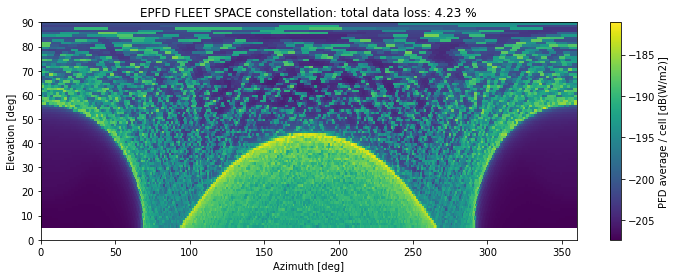

In [36]:
plt.close()
fig = plt.figure(figsize=(12, 4))
val = pfd_avg.to_value(cnv.dB_W_m2)
vmin, vmax = val.min(), val.max()
val_norm = (val - vmin) / (vmax - vmin)
plt.bar(
    grid_info['cell_lon_low'],
    height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
    width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
    bottom=grid_info['cell_lat_low'],
    color=plt.cm.viridis(val_norm),
    align='edge',
    )
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.set_label('PFD average / cell [dB(W/m2)]')
plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
    constellation_name, data_loss
    ))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.xlim((0, 360))
plt.ylim((0, 90))
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_avg_pfd_horizontal.png'.format(basename)),
    bbox_inches='tight', dpi=100,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_avg_pfd_horizontal.pdf'.format(basename)),
    bbox_inches='tight',
    )
plt.show()

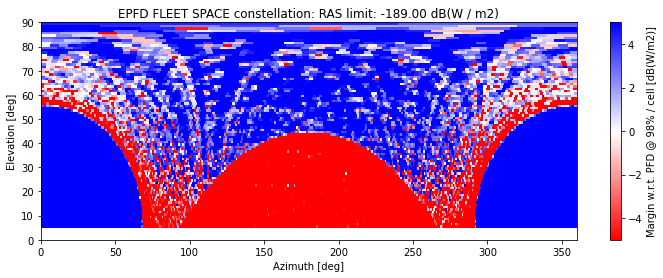

In [37]:
plt.close()
fig = plt.figure(figsize=(12, 4))
val = pfd_lim.to_value(cnv.dB_W_m2) - pfd_98p.to_value(cnv.dB_W_m2)
vmin, vmax = val.min(), val.max()
vmin, vmax = -5, 5
val_norm = (val - vmin) / (vmax - vmin)
plt.bar(
    grid_info['cell_lon_low'],
    height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
    width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
    bottom=grid_info['cell_lat_low'],
    color=plt.cm.bwr_r(val_norm),
    align='edge',
    )
sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr_r, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.set_label('Margin w.r.t. PFD @ 98% / cell [dB(W/m2)]')
plt.title('EPFD {:s} constellation: RAS limit: {:.2f}'.format(
    constellation_name, pfd_lim
    ))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.xlim((0, 360))
plt.ylim((0, 90))
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_margin_wrt_98p_pfd_horizontal.png'.format(basename)),
    bbox_inches='tight', dpi=100,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_margin_wrt_98p_pfd_horizontal.pdf'.format(basename)),
    bbox_inches='tight',
    )
plt.show()

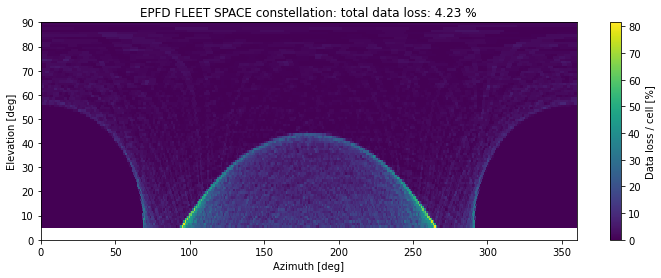

In [38]:
plt.close()
fig = plt.figure(figsize=(12, 4))
val = data_loss_per_cell
vmin, vmax = val.min(), val.max()
val_norm = (val - vmin) / (vmax - vmin)
plt.bar(
    grid_info['cell_lon_low'],
    height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
    width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
    bottom=grid_info['cell_lat_low'],
    color=plt.cm.viridis(val_norm),
    align='edge',
    )
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.set_label('Data loss / cell [%]')
plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
    constellation_name, data_loss
    ))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.xlim((0, 360))
plt.ylim((0, 90))
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_data_loss_horizontal.png'.format(basename)),
    bbox_inches='tight', dpi=100,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_data_loss_horizontal.pdf'.format(basename)),
    bbox_inches='tight',
    )
plt.show()

In [39]:
pfd_dist = (np.sort(pfd_lin) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_dist_all = (np.sort(pfd_lin.flatten()) * u.W / u.m ** 2).to(cnv.dB_W_m2)

Calculate margin at 98% percentile

In [40]:
pfd98p = np.percentile(pfd_lin, 98., axis=1)
pfd98p_all = np.percentile(pfd_lin, 98.)
pfd98p_mean = np.mean(pfd98p)
pfd98p_sigma = np.std(pfd98p, ddof=1)

In [41]:
print_info(
    '98%: pfd = {0.value:.1f} (+{1:.1f} / -{2:.1f}) {0.unit}'.format(
        (pfd98p_all * u.W / u.m ** 2).to(cnv.dB_W_m2),
        np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
    ))

98%: pfd = -182.5 (+0.5 / -0.6) dB(W / m2)


In [42]:
print_info(
    'RAS margin = {:.1f} (+{:.1f} / -{:.1f}) dB'.format(
        pfd_lim.to_value(cnv.dB_W_m2) - (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2),
        np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
    ))

RAS margin = -6.5 (+0.6 / -0.5) dB


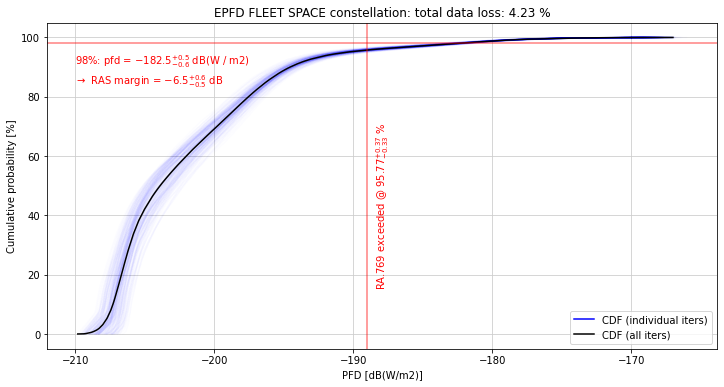

In [43]:
plt.close()
fig = plt.figure(figsize=(12, 6))
plt.plot(
    pfd_dist.T, 100 * np.linspace(0, 1, pfd_dist.shape[1], endpoint=True),
    'b-', alpha=0.01,
    )
plt.plot([], [], 'b-', label='CDF (individual iters)')
plt.plot(
    pfd_dist_all[::20], 100 * np.linspace(0, 1, pfd_dist_all.size, endpoint=True)[::20],
    'k-', label='CDF (all iters)'
    )
hline = plt.axhline(98., color='r', alpha=0.5)
vline = plt.axvline(pfd_lim.to_value(cnv.dB_W_m2), color='r', alpha=0.5)
plt.grid(color='0.8')
plt.title('EPFD {:s} constellation: total data loss: {:.2f}'.format(
    constellation_name, data_loss
    ))
plt.xlabel('PFD [dB(W/m2)]')
plt.ylabel('Cumulative probability [%]')
plt.legend(*plt.gca().get_legend_handles_labels())
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(
    xmin + 2, 95.,
    r'98%: pfd = ${0.value:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}$ {0.unit}'.format(
        (pfd98p_all * u.W / u.m ** 2).to(cnv.dB_W_m2),
        np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        ), color='red', ha='left', va='top',
    )
plt.text(
    xmin + 2, 88.,
    r'$\rightarrow$ RAS margin = ${:.1f}^{{+{:.1f}}}_{{-{:.1f}}}$ dB'.format(
        pfd_lim.to_value(cnv.dB_W_m2) - (pfd98p_all * u.W / u.m ** 2).to_value(cnv.dB_W_m2),
        np.abs(((1 - pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        np.abs(((1 + pfd98p_sigma / pfd98p_mean) * cnv.dimless).to_value(cnv.dB)),
        ), color='red', ha='left', va='top',
    )
plt.text(
    pfd_lim.to_value(cnv.dB_W_m2) + 0.5, ymin + 20,
    r'RA.769 exceeded @ ${0.value:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$ {0.unit}'.format(
        100 * u.percent - data_loss,
        data_loss.to_value(u.percent) - data_loss_m1s,
        data_loss_p1s - data_loss.to_value(u.percent),
        ),
    color='red', ha='left', va='bottom', rotation=90.,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_cumulative_data_loss_horizontal.png'.format(basename)),
    bbox_inches='tight', dpi=100,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_cumulative_data_loss_horizontal.pdf'.format(basename)),
    bbox_inches='tight',
    )
plt.show()

### Equatorial sky

In [44]:
print_info('-' * 80)
print_info('Equatorial frame')
print_info('-' * 80)

--------------------------------------------------------------------------------
Equatorial frame
--------------------------------------------------------------------------------


In [45]:
tel_ra, tel_dec, grid_info = sample_on_cell_grid_m1583(
    niters,
    step_size=grid_size,
    lat_range=eq_lat_range,
    rnd_seed=0,
    )

In [46]:
print_info('Latitude range: {} to {}'.format(*eq_lat_range))

Latitude range: -30.0 deg to 90.0 deg


In [47]:
def equatorial_to_topo_approx(lst_greenwich_deg, obs_lon, obs_lat, ra, dec):
    #by B. Winkel 2020
    
    hour_angle = lst_greenwich_deg - obs_lon - ra

    azim = 180. - np.degrees(np.arctan2(
        np.sin(np.radians(-hour_angle)),
        np.sin(np.radians(obs_lat)) * np.cos(np.radians(hour_angle)) -
        np.cos(np.radians(obs_lat)) * np.tan(np.radians(dec))
        ))
    elev = np.degrees(np.arcsin(
        np.cos(np.radians(obs_lat)) * np.cos(np.radians(hour_angle)) *
        np.cos(np.radians(dec)) +
        np.sin(np.radians(obs_lat)) * np.sin(np.radians(dec))
        ))
    
    return azim, elev

    

In [48]:
p_rx = np.zeros(tel_ra.shape, dtype=np.float64)
chunk_size = 100
nchunks = tel_ra.shape[1] // chunk_size + 1

for niter in ProgressBar(niters, ipython_widget=True):
    vis_mask = topo_pos_el[niter] > 0.
    
    if activity_cycle > 1:
        # only every n-th sample is active
        activity_mask = np.zeros_like(vis_mask)
        # we need to randomize, which satellites emit in which slot, to
        # avoid a "synchronized" transmission
        for s_idx in range(activity_mask.shape[1]):  # loop over all sats
            activity_mask[np.random.randint(activity_cycle)::activity_cycle, s_idx] = True
        
        vis_mask = vis_mask & activity_mask

    FSPL = cnv.free_space_loss(sat_obs_dist[niter, vis_mask, np.newaxis] * u.km, freq).to(cnv.dB)
    G_tx = sat_gain_func(
        sat_obs_az[niter, vis_mask, np.newaxis] * u.deg,
        sat_obs_el[niter, vis_mask, np.newaxis] * u.deg,
        )

    sat_pos_az = topo_pos_az[niter, vis_mask, np.newaxis]
    sat_pos_el = topo_pos_el[niter, vis_mask, np.newaxis]
    
    obstime = Time(mjds[niter], format='mjd')
    _lst_greenwich_deg = obstime.sidereal_time(
        kind='mean', longitude='greenwich'
        ).deg
    lst_greenwich_deg = np.repeat(
        _lst_greenwich_deg[np.newaxis], topo_pos_az.shape[2], axis=0
        ).T[vis_mask]

    for chunk in range(nchunks):
        
        cells_sl = slice(
            chunk * chunk_size, 
            min((chunk + 1) * chunk_size, tel_ra.shape[1])
            )
        
        tel_az, tel_el = equatorial_to_topo_approx(
            lst_greenwich_deg[:, np.newaxis],
            obs_lon, obs_lat,
            tel_ra[niter, np.newaxis, cells_sl],
            tel_dec[niter, np.newaxis, cells_sl]
            )
       
        ang_sep = geometry.true_angular_distance(
            tel_az * u.deg,
            tel_el * u.deg,
            sat_pos_az * u.deg,
            sat_pos_el * u.deg,
            )

        G_rx = antenna.ras_pattern(ang_sep, d_rx, const.c / freq, eta_a_rx)

        _p_rx = (p_tx.to(cnv.dB_W) + G_tx + FSPL + G_rx).to_value(u.W)
        tel_horizon_mask = tel_el < 0.
        # for low declinations, depending on time, telescope would need
        # to point to negative elevation, which is impossible, to target
        # astronomical object; set received power for such cases to zero
        _p_rx[tel_horizon_mask] = 1e-29
        p_rx[niter, cells_sl] = np.sum(_p_rx, axis=0) / mjds.shape[1] * activity_cycle


FloatProgress(value=0.0)

In [49]:
prx_file = pjoin(DATAPATH, basename + '_equatorial_prx.npy')
aux_file = pjoin(DATAPATH, basename + '_equatorial_aux.npz')

In [50]:
np.save(prx_file, p_rx)
np.savez(
    aux_file,
    tel_az=tel_az,
    tel_el=tel_el,
    grid_info=grid_info,
    pfd_lim_W_m2=pfd_lim.to_value(u.W / u.m ** 2),
    frequency_ghz=freq.to_value(u.GHz),
    designations=(designation, constellation_name),
    observer_names=(observer_name, observer_tname),
    obs_pos=(obs_lon, obs_lat, obs_alt),
    eq_lat_range=(eq_lat_range[0].to_value(u.deg), eq_lat_range[1].to_value(u.deg)),
    )

In [51]:
# p_rx = np.load(prx_file)
# _aux = np.load(aux_file)
# tel_az = _aux['tel_az']
# tel_el = _aux['tel_el']
# grid_info = _aux['grid_info']
# pfd_lim = _aux['pfd_lim_W_m2'] * u.W / u.m ** 2
# freq = _aux['frequency_ghz'] * u.GHz
# designation, constellation_name = _aux['designations']
# observer_name, observer_tname = _aux['observer_names']
# obs_lon, obs_lat, obs_alt = _aux['obs_pos']
# eq_lat_range = _aux['eq_lat_range'] * u.deg

In [52]:
pfd = cnv.powerflux_from_prx(p_rx * u.W, freq, 0 * cnv.dBi).to(cnv.dB_W_m2)

pfd_lin = pfd.to_value(u.W / u.m ** 2)
pfd_avg = (np.mean(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_98p = (np.percentile(pfd_lin, 98., axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)
pfd_max = (np.max(pfd_lin, axis=0) * u.W / u.m ** 2).to(cnv.dB_W_m2)

data_loss_per_cell = np.array([
    100 - percentileofscore(pl, pfd_lim.to_value(u.W / u.m ** 2), kind='strict')
    for pl in pfd_lin.T
    ])

In [53]:
bad_cells = np.count_nonzero(pfd_avg > pfd_lim)
print_info('number of sky cells above threshold: {:d} ({:.2f} %)'.format(
    bad_cells, 100 * bad_cells / len(grid_info)
    ))

number of sky cells above threshold: 1207 (3.90 %)


In [54]:
bad2p_cells = np.count_nonzero(data_loss_per_cell > 2.)
bad5p_cells = np.count_nonzero(data_loss_per_cell > 5.)
print_info('number of sky cells with more than 2% data loss: {:d} / {:d})'.format(
    bad2p_cells, len(grid_info)
    ))
print_info('number of sky cells with more than 5% data loss: {:d} / {:d})'.format(
    bad5p_cells, len(grid_info)
    ))

number of sky cells with more than 2% data loss: 13733 / 30938)
number of sky cells with more than 5% data loss: 5699 / 30938)


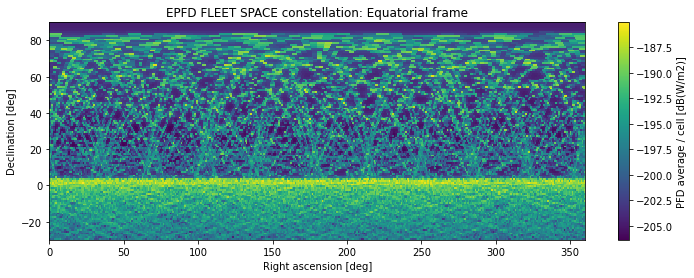

In [55]:
plt.close()
fig = plt.figure(figsize=(12, 4))
val = pfd_avg.to_value(cnv.dB_W_m2)
vmin, vmax = val.min(), val.max()
val_norm = (val - vmin) / (vmax - vmin)
plt.bar(
    grid_info['cell_lon_low'],
    height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
    width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
    bottom=grid_info['cell_lat_low'],
    color=plt.cm.viridis(val_norm),
    align='edge',
    )
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.set_label('PFD average / cell [dB(W/m2)]')
plt.title('EPFD {:s} constellation: Equatorial frame'.format(
    constellation_name
    ))
plt.xlabel('Right ascension [deg]')
plt.ylabel('Declination [deg]')
plt.xlim((0, 360))
plt.ylim((eq_lat_range[0].to_value(u.deg), eq_lat_range[1].to_value(u.deg)))
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_avg_pfd_equatorial.png'.format(basename)),
    bbox_inches='tight', dpi=100,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_avg_pfd_equatorial.pdf'.format(basename)),
    bbox_inches='tight',
    )
plt.show()

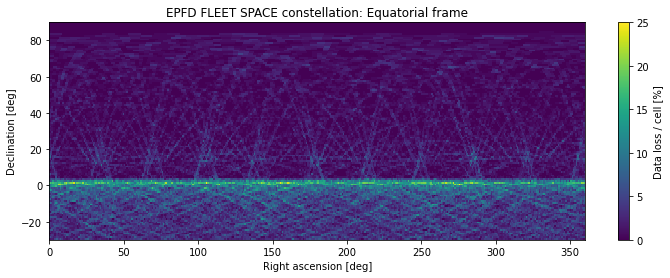

In [56]:
plt.close()
fig = plt.figure(figsize=(12, 4))
val = data_loss_per_cell
vmin, vmax = val.min(), val.max()
val_norm = (val - vmin) / (vmax - vmin)
plt.bar(
    grid_info['cell_lon_low'],
    height=grid_info['cell_lat_high'] - grid_info['cell_lat_low'],
    width=grid_info['cell_lon_high'] - grid_info['cell_lon_low'],
    bottom=grid_info['cell_lat_low'],
    color=plt.cm.viridis(val_norm),
    align='edge',
    )
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm)
cbar.set_label('Data loss / cell [%]')
plt.title('EPFD {:s} constellation: Equatorial frame'.format(
    constellation_name
    ))
plt.xlabel('Right ascension [deg]')
plt.ylabel('Declination [deg]')
plt.xlim((0, 360))
plt.ylim((eq_lat_range[0].to_value(u.deg), eq_lat_range[1].to_value(u.deg)))
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_data_loss_equatorial.png'.format(basename)),
    bbox_inches='tight', dpi=100,
    )
plt.savefig(
    pjoin(FIGPATH, '{:s}_skygrid_data_loss_equatorial.pdf'.format(basename)),
    bbox_inches='tight',
    )
plt.show()